<a href="https://colab.research.google.com/github/julienroy13/competitive_gradient_descent/blob/master/gan_cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Training code referenced
 from: https://github.com/afiliot/GANs-And-VAEs-For-Gaussian-Mixture/blob/master/DLIP-MP1-GAN-VAE-FILIOT.ipynb

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



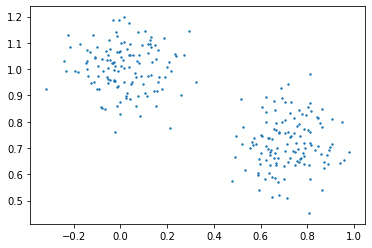

In [2]:
def generate_batch(batchlen,plot=False):
  
  cov = torch.tensor(np.identity(2)*0.01, dtype=torch.float64)
  mu1 = torch.tensor([2**(-1/2), 2**(-1/2)], dtype=torch.float64)
  mu2 = torch.tensor([0,1], dtype=torch.float64)
  
  gaussian1 = MultivariateNormal(loc=mu1, covariance_matrix=cov)
  gaussian2 = MultivariateNormal(loc=mu2, covariance_matrix=cov)

  data = []
  d1 = gaussian1.rsample((int(batchlen/2),))
  d2 = gaussian2.rsample((int(batchlen/2),))

  data = np.concatenate((d1, d2), axis=0)
  np.random.shuffle(data)

  if plot:
    plt.scatter(data[:,0],data[:,1], s=2.0)
  return torch.Tensor(data).to(device)

batch = generate_batch(256, plot=True)


In [0]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_size=0, noise_size=1, noise_std=1.):
        super().__init__()
        self.noise_size = noise_size
        self.noise_std = noise_std

        # First layer
        self.fc1 = nn.Linear(noise_size, hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        self.fc6 = nn.Linear(hidden_size, 2)


    def __call__(self, z):
        h = F.relu(self.fc1(z))

        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))

        return self.fc6(h)

    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.noise_size), self.noise_std)
        return self.__call__(z)
    

# Define the discriminator.
class Discriminator(nn.Module):
    def __init__(self, hidden_size=0):
        super().__init__()

        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 1)


    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        # return torch.sigmoid(self.fc6(x))
        return self.fc6(x)


In [0]:
def compute_hessian(grads, params):
    H = []
    for i, (grad, p) in enumerate(zip(grads, params)):
        grad = grad.reshape(-1)
        d = len(grad)
        dg = torch.zeros((d, d))
        print (dg)
        for j, g in enumerate(grad):
            g2 = autograd.grad(g, p, create_graph=True)[0].view(-1)
            dg[j] = g2

        H.append(dg)
    print (H)
    return H

In [0]:
def CGD_step(x, y, out_f, out_g, eta=0.005):
  
    df_dx = torch.autograd.grad(out_f, x, create_graph=True)
    df_dy = torch.autograd.grad(out_f, y, create_graph=True)
    dg_dx = torch.autograd.grad(out_g, x, create_graph=True)
    dg_dy = torch.autograd.grad(out_g, y, create_graph=True)
    # print (df_dx)

    
    # d2f_dxdy = torch.autograd.grad(df_dx, y, create_graph=False)[0]
    # d2g_dydx = torch.autograd.grad(dg_dy, x, create_graph=False)[0]
    d2f_dxdy = compute_hessian(df_dx, y)
    d2g_dydx = compute_hessian(dg_dy, x)
    
    
    print (d2f_dxdy)
    
    step_x = ((1. / (1. - (eta ** 2.) * d2f_dxdy * d2g_dydx)) * (df_dx - eta * d2f_dxdy * dg_dy))
    step_y = ((1. / (1. - (eta ** 2.) * d2g_dydx * d2f_dxdy)) * (dg_dy - eta * d2g_dydx * df_dx))

    return step_x, step_y


In [0]:
def GAN(TRAIN_RATIO=1, N_ITER=5000, BATCHLEN=128,
        hidden_size_G=0, hidden_size_D=0,
        noise_size=1, noise_std=1., frame=1000):
    """
    TRAIN_RATIO : int, number of times to train the discriminator between two generator steps
    N_ITER : int, total number of training iterations for the generator
    BATCHLEN : int, Batch size to use
    hidden_size_G : int, width of the generator (number of neurons in hidden layers)
    hidden_size_D : int, width of the discriminator (number of neurons in hidden layers)
    noise_size : int, dimension of input noise
    noise_std : float, standard deviation of p(z)
    frame : int, display data each 'frame' iteration
    """

    G = Generator(hidden_size=hidden_size_G, noise_size=noise_size, noise_std=noise_std)
    solver_G = torch.optim.SGD(G.parameters(), lr=1e-3)
    D = Discriminator(hidden_size=hidden_size_D)
    solver_D = torch.optim.SGD(D.parameters(), lr=1e-4)

    for i in tqdm(range(N_ITER)):
        # train the discriminator
        for _ in range(TRAIN_RATIO):
            D.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = G.generate(BATCHLEN)

            # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
            # torch.softplus, using real_batch and fake_batch
            h_real = D(real_batch)
            h_fake = D(fake_batch)
            loss_real = torch.mean(torch.sum(F.softplus(-h_real)))
            loss_fake = torch.mean(torch.sum(F.softplus(h_fake)))
            disc_loss = loss_real + loss_fake

        # train the generator
        G.zero_grad()
        fake_batch = G.generate(BATCHLEN)
        # Compute here the generator loss, using fake_batch
        h_fake = D(fake_batch)
        gen_loss = - torch.mean(torch.sum(F.softplus(h_fake)))

        # TDOO: cgd here
        step_x, step_y = CGD_step(x=(D.parameters()), y=(G.parameters()), out_f=disc_loss, out_g=gen_loss)
        print ("step x")
        print (step_x)
        break
        solver_D.step()
        solver_G.step()
        
        
        
        if i%frame == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = G.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()

In [0]:
GAN(TRAIN_RATIO=2, N_ITER=5000, BATCHLEN=128,
    hidden_size_G=128, hidden_size_D=128,
    noise_size=512, noise_std=6, frame=100)

[]
[]
[]



TypeError: ignored

In [0]:
BATCHLEN=128
hidden_size_G=100
hidden_size_D=100
noise_size = 500
noise_std=6


G = Generator(hidden_size=hidden_size_G, noise_size=noise_size, noise_std=noise_std)
solver_G = torch.optim.SGD(G.parameters(), lr=1e-3)
D = Discriminator(hidden_size=hidden_size_D)
solver_D = torch.optim.SGD(D.parameters(), lr=1e-4)

D.zero_grad()
G.zero_grad()
fake_batch = G.generate(BATCHLEN)
# Compute here the generator loss, using fake_batch
h_fake = D(fake_batch)
gen_loss = - torch.mean(torch.sum(F.softplus(h_fake)))



In [0]:
 df_dx = torch.autograd.grad(gen_loss, G.parameters(), create_graph=True)

In [0]:
  H = []
  for i, (grad, p) in enumerate(zip(df_dx, G.parameters())):
      grad = grad.reshape(-1)
      d = len(grad)
      dg = torch.zeros((d, d))
      for j, g in tqdm(enumerate(grad)):
          g2 = autograd.grad(g, p, create_graph=True)[0].view(-1)
          # print (g2)
          dg[j] = g2

      H.append(dg)
  print (H)


In [0]:
H